In [1]:
!pip install -qqq PyPDF2

In [2]:
!git clone https://github.com/uakarsh/sample_rvl_cdip_dataset.git

Cloning into 'sample_rvl_cdip_dataset'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 0), reused 23 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), 711.04 KiB | 4.02 MiB/s, done.


In [3]:
!find '/kaggle/working/sample_rvl_cdip_dataset/IDL Pre-training dataset/ocrs' -type f > ocr_files.txt

## 1. Download IDL PDF (this can be the file named as `download_idl_pdf.py`)

In [4]:
import os
from pathlib import Path
import requests
from tqdm.auto import tqdm
from joblib import Parallel, delayed

def download_and_store_pdf(file_path) -> int:

    url = "https://download.industrydocuments.ucsf.edu"
    sample_file = file_path
    actual_path = sample_file.replace('ocrs', 'pdfs').split("/")[:-1]
    file_name = sample_file.split("/")[-1].split(".")[0] + ".pdf"

    dest_path = "/".join(actual_path) if file_path[0] == '/' else os.path.join(*actual_path)
    os.makedirs(dest_path, exist_ok=True)
    for i in actual_path[6:]:
        url = url + "/" + i
    url = url + "/" + actual_path[-1]
    url = url + ".pdf"

    try:
        response = requests.get(url)
        dest_path = os.path.join(dest_path, file_name)
        filename = Path(dest_path)
        filename.write_bytes(response.content)
        return 1
    except:
        return 0

In [5]:
# if True:
#     file_path = '/kaggle/working/sample_rvl_cdip_dataset/IDL Pre-training dataset/ocrs/f/f/b/b/ffbb0000/ffbb0000.json'
#     url = "https://download.industrydocuments.ucsf.edu"
#     sample_file = file_path
#     actual_path = sample_file.replace('ocrs', 'pdfs').split("/")[:-1]
#     file_name = sample_file.split("/")[-1].split(".")[0] + ".pdf"

#     dest_path = "/".join(actual_path) if file_path[0] == '/' else os.path.join(*actual_path)
#     os.makedirs(dest_path, exist_ok=True)
#     for i in actual_path[6:]:
#         url = url + "/" + i
#     url = url + "/" + actual_path[-1]
#     url = url + ".pdf"
    
#     if True:
#         response = requests.get(url)
# #         dest_path = os.path.join(dest_path, file_name)
# #         filename = Path(dest_path)
# #         filename.write_bytes(response.content)

In [6]:
if __name__ == '__main__':
    with open("/kaggle/working/ocr_files.txt") as x:
        alist = [line.rstrip() for line in x]
    total_length = len(alist)
    
    print(f"Total files are {total_length}")
    ## For each entry in the list, download the pdf using joblib and download_and_store_pdf
    out = 0
    batch = 100
    for i in tqdm(range(0, total_length, batch), total = total_length//batch):
        ## Parallelize the below function
        sample_output =  Parallel(n_jobs= -1, backend = "multiprocessing")(delayed(download_and_store_pdf)(alist[j]) for j in range(i, min(i+batch, total_length)))
        # print("sample_output", sample_output)
        out += sum(sample_output)
        # out += download_and_store_pdf(alist[i])
    
    print(f"Total files downloaded are {out}")
    print(f"Total files not downloaded are {total_length - out}, and in percentage {(total_length - out)/total_length * 100} %")

Total files are 1


0it [00:00, ?it/s]

Total files downloaded are 1
Total files not downloaded are 0, and in percentage 0.0 %


In [7]:
!find '/kaggle/working/sample_rvl_cdip_dataset/IDL Pre-training dataset/pdfs' -type f > pdf_files.txt

## 2. Check the intersection of OCR's and PDF's (name can be `ocr_pdf_file_intersection.py`)

* Since, there can be times when the PDF's haven't been downloaded, let's create a CSV file, for which both the `json` and the `pdf` path exists

In [8]:
## read lines from a text file named ocr_files.txt and store it in a set

with open("ocr_files.txt", "r") as f:
    ocrs = f.readlines()
    ocrs = [line.strip().split(".")[0].replace("ocrs", "*") for line in ocrs]

## create a set of the lines
ocrs = set(ocrs)

with open("pdf_files.txt", "r") as f:
    pdfs = f.readlines()
    pdfs = [line.strip().split(".")[0].replace("pdfs", "*") for line in pdfs]

## create a set of the lines
pdfs = set(pdfs)

## intersection of pdfs and ocrs
intersection = pdfs.intersection(ocrs)

import pandas as pd
pdf_path = []
ocr_path = []

for i in intersection:
    pdf_path.append(i.replace("*", "pdfs") + ".pdf")
    ocr_path.append(i.replace("*", "ocrs") + ".json")

df = pd.DataFrame({"pdf_path": pdf_path, "ocr_path": ocr_path})
df.to_csv("ocr_pdf.csv", index=False)

## Heads up -> Until now, we have been able to download the PDF files corresponding to the JSON files using Joblib. Now, we need to prepare the data in an image + OCR manner, so that we can keep it in a format, our model needs

## 3. Prepare the IDL Dataset from Path

In [9]:
# Getting the JSON File

import json
import pandas as pd

# For reading the PDFs
from PyPDF2 import PdfReader
import io
from PIL import Image, ImageDraw

# Standard library
import os
from typing import List

from tqdm.auto import tqdm
import argparse
from joblib import Parallel, delayed

# Image property
resize_scale = (500, 500)

def normalize_box(box: List[int], width: int, height: int, size: tuple = resize_scale):
    """
    Takes a bounding box and normalizes it to a thousand pixels. If you notice it is
    just like calculating percentage except takes 1000 instead of 100.
    """
    return [
        int(size[0] * (box[0] / width)),
        int(size[1] * (box[1] / height)),
        int(size[0] * (box[2] / width)),
        int(size[1] * (box[3] / height)),
    ]


# Function to get the images from the PDFs as well as the OCRs for the corresponding images
def get_image_ocrs_from_path(pdf_file_path: str, ocr_file_path: str, resize_scale=resize_scale,
                             save_folder_img: str = "./images", save_folder_ocr: str = "./ocrs"):

    # Making folder to save the images
    if not os.path.exists(save_folder_img):
        os.mkdir(save_folder_img)

    # Making folder to save the OCRs
    if not os.path.exists(save_folder_ocr):
        os.mkdir(save_folder_ocr)

    try:

        # Getting the image list, since the pdfs can contain many image
        reader = PdfReader(pdf_file_path)
        img_list = {}
        pg_count = 1
        for i in range(len(reader.pages)):
            page = reader.pages[i]
            for image_file_object in page.images:

                stream = io.BytesIO(image_file_object.data)
                img = Image.open(stream).convert("RGB").resize(resize_scale)
                path_name = os.path.join(
                    save_folder_img, f"{pdf_file_path.split('/')[-1].split('.')[0]}_{pg_count}.png")
                pg_count += 1
                img.save(path_name)
                img_list[pg_count - 1] = path_name

        json_entry = json.load(open(ocr_file_path))[1]
        json_entry = [x for x in json_entry["Blocks"] if "Text" in x]

        pages = [x["Page"] for x in json_entry]
        ocrs = {pg: [] for pg in set(pages)}

        for entry in json_entry:
            bbox = entry["Geometry"]["BoundingBox"]
            x, y, w, h = bbox['Left'], bbox['Top'], bbox["Width"], bbox["Height"]
            bbox = [x, y, x + w, y + h]
            # bbox = normalize_box(bbox, width=1, height=1, size=resize_scale)
            ocrs[entry["Page"]].append({"word": entry["Text"], "bbox": bbox})

        ocr_path = {}
        for pg in set(pages):
            path_name = os.path.join(
                save_folder_ocr, f"{pdf_file_path.split('/')[-1].split('.')[0]}_{pg}.json")
            with open(path_name, "w") as f:
                json.dump(ocrs[pg], f)
            ocr_path[pg] = path_name

        return img_list, ocr_path

    except:
        return {}, {}


# Function to get the OCRs for the corresponding images
def get_ocrs_from_path(ocr_file_path: str, save_folder_ocr: str = "./ocrs"):

    # Making folder to save the OCRs
    if not os.path.exists(save_folder_ocr):
        os.mkdir(save_folder_ocr)

    try:

        json_entry = json.load(open(ocr_file_path))[1]
        json_entry = [x for x in json_entry["Blocks"] if "Text" in x]

        pages = [x["Page"] for x in json_entry]
        ocrs = {pg: [] for pg in set(pages)}

        for entry in json_entry:
            bbox = entry["Geometry"]["BoundingBox"]
            x, y, w, h = bbox['Left'], bbox['Top'], bbox["Width"], bbox["Height"]
            bbox = [x, y, x + w, y + h]
            # bbox = normalize_box(bbox, width=1, height=1, size=resize_scale)
            ocrs[entry["Page"]].append({"word": entry["Text"], "bbox": bbox})

        ocr_path = {}
        for pg in set(pages):
            path_name = os.path.join(
                save_folder_ocr, f"{ocr_file_path.split('/')[-1].split('.')[0]}_{pg}.json")
            with open(path_name, "w") as f:
                json.dump(ocrs[pg], f)
            ocr_path[pg] = path_name

        return ocr_path

    except:
        return {}

# Function to get the images from the PDFs as well as the OCRs for the corresponding images without saving the image
def get_image_ocrs_dict_from_path(pdf_file_path: str, ocr_file_path: str):

    #try:
        # Getting the image list, since the pdfs can contain many image
        reader = PdfReader(pdf_file_path)
        img_list = {}
        pg_count = 1
        for i in range(len(reader.pages)):
            page = reader.pages[i]
            for image_file_object in page.images:
                pdf_name = pdf_file_path.split('/')[-1].split('.')[0]
                pg_count += 1
                img_list[pg_count - 1] = pdf_file_path

        json_entry = json.load(open(ocr_file_path, 'r'))[1]
        json_entry = [x for x in json_entry["Blocks"] if "Text" in x]

        pages = [x["Page"] for x in json_entry]
        ocrs = {pg: [] for pg in set(pages)}

        for entry in json_entry:
            bbox = entry["Geometry"]["BoundingBox"]
            x, y, w, h = bbox['Left'], bbox['Top'], bbox["Width"], bbox["Height"]
            bbox = [x, y, x + w, y + h]
            ocrs[entry["Page"]].append({"word": entry["Text"], "bbox": bbox})

        ocr_path = {}
        for pg in set(pages):
            ocr_path[pg-1] = ocr_file_path
        
        #print(img_list)
        return img_list, ocr_path

#     except:
#         return {}, {}

if __name__ == "__main__":
        csv_path = '/kaggle/working/ocr_pdf.csv'
        df = pd.read_csv(csv_path)
        
        pdf_path = df.pdf_path.values.tolist()
        ocr_path = df.ocr_path.values.tolist()

        img_list = []
        ocr_list = []

        pdf_files = sorted(pdf_path)
        ocr_files = sorted(ocr_path)

        img_list = []
        ocr_list = []
        pg_list = []

        step_size = 100
        for i in tqdm(range(0, len(pdf_files), step_size), total = len(pdf_files) // step_size):
            entries = Parallel(n_jobs=-1, backend="multiprocessing")(delayed(get_image_ocrs_dict_from_path)
                                                                          (pdf_file_path=pdf_files[i],
                                                                        ocr_file_path=ocr_files[i])
                                                                          for i in range(i, min(i+step_size, len(pdf_files))))
            for entry in entries:
                img, ocrs = entry
                for key in list(img.keys()):
                    if key in ocrs:
                        img_list.append(img[key])
                        ocr_list.append(ocrs[key])
                        pg_list.append(key)


        import pandas as pd
        df = pd.DataFrame({"img_list" : img_list, "ocr_list" : ocr_list, "pg_num" : pg_list})
        df.to_csv("true_data_path.csv", index = False)

        print(
            f"Total length of images and ocrs are : {len(img_list)} and {len(ocr_list)} respectively.")

0it [00:00, ?it/s]

Total length of images and ocrs are : 2 and 2 respectively.


## 4. Let's run it

In [10]:
def normalize_box(box : List[int], width : int, height : int, size : tuple = (1000, 1000)):
    """
    Takes a bounding box and normalizes it to a thousand pixels. If you notice it is
    just like calculating percentage except takes 1000 instead of 100.
    """
    return [
        int(size[0] * (box[0] / width)),
        int(size[1] * (box[1] / height)),
        int(size[0] * (box[2] / width)),
        int(size[1] * (box[3] / height)),
    ]


def get_img_bounding_box(pdf_path : str, ocr_path : str, pg_num : int):
  
  ## Creating a blank white image  
  reader = PdfReader(pdf_path)
  page = list(reader.pages)[pg_num]
  image_file_object = page.images[0]
  stream = io.BytesIO(image_file_object.data)
  img = Image.open(stream).convert("RGB")#.resize((1000, 1000))
  
  json_entry = json.load(open(ocr_path))[1]
  json_entry = [x for x in json_entry["Blocks"] if "Text" in x and (x["Page"] -1 == pg_num)]
  ocr = []

  for entry in json_entry:
      bbox = entry["Geometry"]["BoundingBox"]
      x, y, w, h = bbox['Left'], bbox['Top'], bbox["Width"], bbox["Height"]
      bbox = [x, y, x + w, y + h]
      bbox = normalize_box(bbox, width=1, height=1, size= (1000, 1000))
      # if entry["Page"] == pg_num + 1:
      ocr.append({"word": entry["Text"], "bbox": bbox})

  return img.resize((1000, 1000)), ocr

In [11]:
df = pd.read_csv("/kaggle/working/true_data_path.csv")
idx = 0
sample = df.iloc[idx]

In [12]:
img, ocr = get_img_bounding_box(pdf_path = sample['img_list'], ocr_path = sample['ocr_list'], pg_num = sample['pg_num'])

In [13]:
from PIL import Image, ImageDraw

# create rectangle image
draw_on_img = ImageDraw.Draw(img)  

for it in ocr:
  draw_on_img.rectangle(it['bbox'], outline ="red")

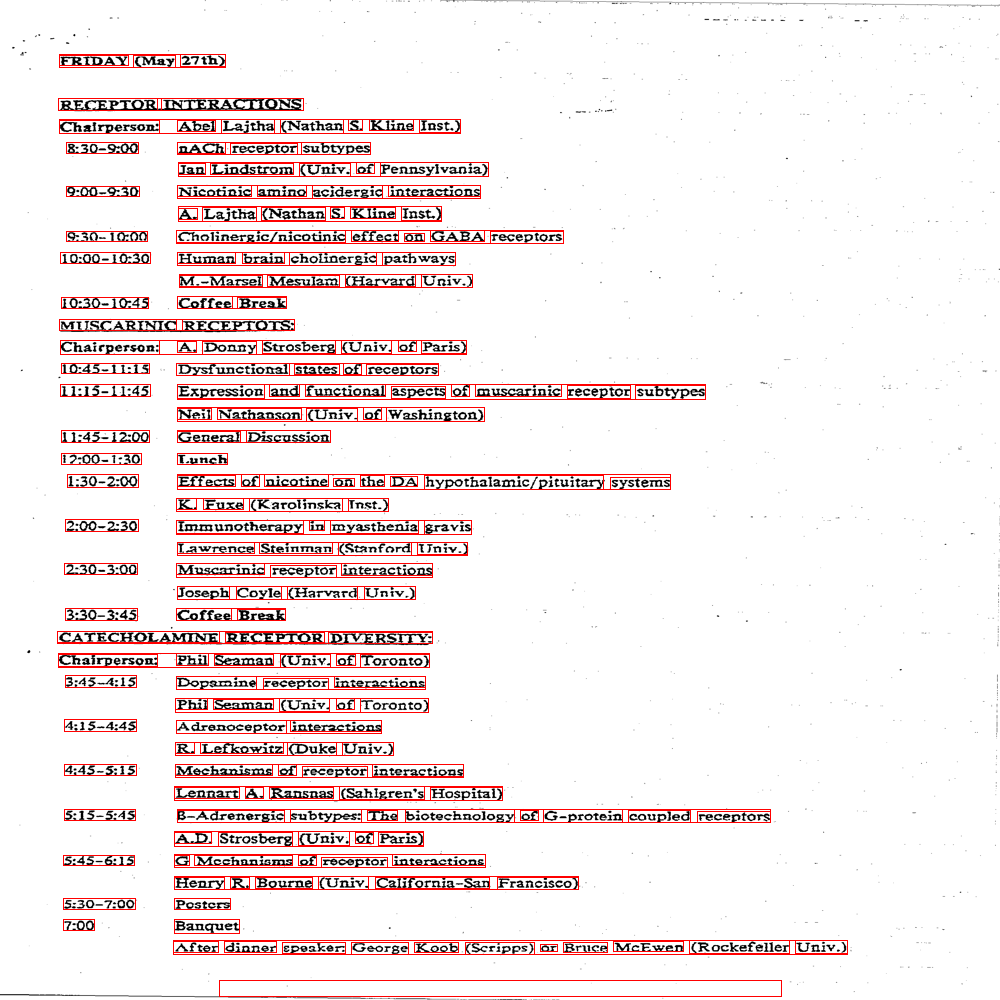

In [14]:
img